In [22]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt

In [23]:
f_name = 'train_val_data.csv'
token_dict = get_token_freq(f_name)

In [24]:
token_dict

{'x33': 4504,
 'x41': 4212,
 'x160': 4716,
 'x195': 6819,
 'x150': 6239,
 'x51': 4174,
 'x122': 4288,
 'x18': 2701,
 'x154': 2889,
 'x80': 2466,
 'x183': 746,
 'x134': 814,
 'x155': 701,
 'x5': 2387,
 'x206': 9981,
 'x188': 8060,
 'x24': 9302,
 'x1': 3664,
 'x141': 5389,
 'x149': 5778,
 'x91': 3827,
 'x211': 1782,
 'x76': 1801,
 'x193': 1086,
 'x213': 594,
 'x37': 983,
 'x16': 6708,
 'x158': 1649,
 'x64': 6497,
 'x62': 1348,
 'x38': 1775,
 'x205': 3112,
 'x88': 8509,
 'x176': 5984,
 'x19': 12640,
 'x223': 4593,
 'x6': 6088,
 'x81': 2968,
 'x56': 608,
 'x142': 5508,
 'x98': 433,
 'x210': 2661,
 'x97': 1134,
 'x219': 1216,
 'x83': 5380,
 'x7': 5019,
 'x121': 454,
 'x153': 166,
 'x197': 2532,
 'x185': 8713,
 'x225': 6572,
 'x69': 2757,
 'x42': 8169,
 'x244': 171,
 'x68': 1380,
 'x212': 1940,
 'x180': 4343,
 'x192': 3670,
 'x104': 1474,
 'x231': 4269,
 'x54': 3593,
 'x113': 826,
 'x170': 2045,
 'x146': 8966,
 'x106': 1755,
 'x125': 1298,
 'x11': 2375,
 'x71': 6510,
 'x187': 2165,
 'x47': 6

In [25]:
len(token_dict)

256

In [26]:
sorted_token_freq = sorted(token_dict.items(), key=lambda x: x[1], reverse=False)

In [27]:
sorted_token_freq

[('x26', 68),
 ('x132', 72),
 ('x137', 84),
 ('x74', 103),
 ('x86', 133),
 ('x103', 136),
 ('x124', 148),
 ('x153', 166),
 ('x244', 171),
 ('x216', 205),
 ('x115', 216),
 ('x75', 250),
 ('x148', 253),
 ('x118', 255),
 ('x165', 277),
 ('x196', 291),
 ('x44', 297),
 ('x94', 358),
 ('x242', 367),
 ('x107', 379),
 ('x57', 384),
 ('x98', 433),
 ('x21', 436),
 ('x109', 443),
 ('x121', 454),
 ('x228', 474),
 ('x207', 480),
 ('x227', 518),
 ('x117', 522),
 ('x222', 530),
 ('x248', 531),
 ('x178', 557),
 ('x87', 558),
 ('x143', 566),
 ('x177', 576),
 ('x213', 594),
 ('x198', 605),
 ('x56', 608),
 ('x78', 614),
 ('x161', 615),
 ('x129', 621),
 ('x186', 637),
 ('x218', 646),
 ('x173', 667),
 ('x131', 684),
 ('x73', 685),
 ('x155', 701),
 ('x139', 711),
 ('x183', 746),
 ('x108', 775),
 ('x239', 780),
 ('x140', 784),
 ('x126', 796),
 ('x249', 798),
 ('x134', 814),
 ('x215', 820),
 ('x113', 826),
 ('x236', 854),
 ('x136', 869),
 ('x168', 885),
 ('x167', 889),
 ('x190', 896),
 ('x101', 974),
 ('x37',

<BarContainer object of 256 artists>

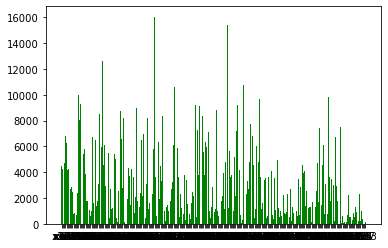

In [28]:
plt.bar(token_dict.keys(), token_dict.values(), color='g')

In [ ]:
from pathlib import Path
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from transformers import RobertaTokenizerFast

### prepare tokenizer

In [ ]:
paths = [str(x) for x in Path("data").glob("*.txt")]

In [ ]:
# initialize a tokenizer

tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer()
tokenizer.train(files=paths, trainer=trainer)

In [ ]:
# test if codewords are tokenized correctly - yes!

f = open(paths[2], 'r')
text = f.read()
output = tokenizer.encode(text)
print(output.ids[:5])
print(output.tokens[:5])

In [ ]:
tokenizer.save('tokenizer/bert-tokenizer.json')

In [ ]:
import json

tokenizer_info = json.load(open('tokenizer/bert-tokenizer.json', 'r'))

with open('tokenizer/vocab.json', 'w') as file:
    json.dump(tokenizer_info['model']['vocab'], file)

with open('tokenizer/merges.json', 'w') as file:
    json.dump(tokenizer_info['model']['merges'], file)

In [ ]:
tokenizer_load = RobertaTokenizerFast.from_pretrained('tokenizer')

### build custom datasets

In [ ]:
import pandas as pd
from torch.utils.data.dataset import Dataset

In [ ]:

class CustomDataset(Dataset):
    
    def __init__(self, df, tokenizer):

        self.examples = []
        # encode sequence into token ids
        for example in df.values:
            #x = tokenizer.encode_plus(example, truncation=True, padding=True)
            x = tokenizer.encode_plus(example)
            self.examples += [x.input_ids]
    
    def __len__(self):
        
        return len(self.examples)
    
    def __getitem__(self, i):
        return torch.tensor(self.examples[i])

In [ ]:
df = pd.read_csv('train_val_data.csv')

train_df = df[df['is_valid'] == 0]
valid_df = df[df['is_valid'] == 1]

train_dataset = CustomDataset(train_df['codewords'], tokenizer_load)
valid_dataset = CustomDataset(valid_df['codewords'], tokenizer_load)

### build language model

In [ ]:
import torch
import math
from transformers import RobertaConfig, RobertaModel, RobertaForMaskedLM
from transformers import RobertaTokenizerFast
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import pipeline

In [ ]:
configuration = RobertaConfig(vocab_size=256)
model = RobertaForMaskedLM(configuration)
print('Num parameters: ', model.num_parameters())

Huggingface assumed `bert-tokenizer` was a path, a model identifier, or url to a directory containing vocabulary files named `['vocab.json', 'merges.txt']` but couldn't find such vocabulary files at this path or url.

In [ ]:
tokenizer_load = RobertaTokenizerFast.from_pretrained('tokenizer')

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer_load, mlm=True, mlm_probability=0.15
)

In [ ]:
# Create the trainer for our model

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

In [ ]:
# Train the model

trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

In [ ]:
trainer.save_model('BERT_models')

In [ ]:
fill_mask = pipeline(
    "fill-mask",
    model='BERT_models',
    tokenizer=tokenizer_load
)

In [ ]:
fill_mask("X23 <mask>")

### fine-tune LM on genre classfication

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

In [ ]:

def preprocess_for_bert(data, tokenizer, max_len):
    
    input_ids = []
    attention_masks = []
    
    for sent in data:
        
        encoded_sent = tokenizer.encode_plus(
            text = sent,
            max_length = max_len,
            pad_to_max_length = True,
            truncation=True,
            return_attention_mask = True)
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        
        # convert lists to tensors
        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        
        return input_ids, attention_masks

In training for genre classification, we take the list of codewords for one audio clip as one senetence. 

we need to find the maximum length of our sentences from all of the codeword representations of the GTZAN dataset, which is MAX_LEN.

* what form should `sent` be?

**Find the maximum length of sentences**

In [ ]:
train_val_data = pd.read_csv('train_val_data.csv')
test_data = pd.read_csv('test_data.csv')

all_codewords = np.concatenate([train_val_data['codewords'].values, 
               test_data['codewords'].values])

print(f"Total number of 'sentences': {all_codewords.size}")

In [ ]:
max_len = max([len(sent) for sent in all_codewords])
print('Max length: ', max_len)

**Tokenize our data**

In [ ]:
original = train_val_data['codewords'][0]
encoded = preprocess_for_bert(original, tokenizer_load, max_len)
print(f'Original: {original}\nEncode: {encoded}')

In [ ]:
X_train = train_val_data[(train_val_data['is_valid']==0)]['codewords'].values
X_val = train_val_data[(train_val_data['is_valid']==1)]['codewords'].values

y_train = train_val_data[(train_val_data['is_valid']==0)]['genre'].values
y_val = train_val_data[(train_val_data['is_valid']==1)]['genre'].values

train_inputs, train_masks = preprocess_for_bert(X_train, tokenizer_load, max_len)
val_inputs, val_masks = preprocess_for_bert(X_val, tokenizer_load, max_len)

**Create Pytorch DataLoader**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
from helpers import *

In [ ]:
y_train = one_hot_encode(train_val_data[train_val_data['is_valid']==0], 'genre')
y_val = one_hot_encode(train_val_data[train_val_data['is_valid']==1], 'genre')

# Convert other data types to torch.Tensor

train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
print(train_labels, '\n', val_labels)

In [ ]:
# create dataloader for training set
# train_data = TensorDataset(train_inputs, train_masks, train_labels)
print(train_inputs.shape, train_masks.shape, train_labels.shape)

**Create BERT classifier for genre identification**

In [ ]:
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
class GenreClassifier(nn.Module):
    
    def __init__(self, tokenizer, free_bert=False):
        
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 10
        self.bert = RobertaTokenizerFast.from_pretrained('tokenizer')
        
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    
    def forward(self, input_ids, attention_mask):
        
        # get outputs from Bert
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # extract the last hidden state for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        
        # compute logits
        logits = self.classifier(last_hidden_state_cls)
        
        return logits

In [ ]:
def initialize_model(epochs=4):

    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

**training**

In [ ]:
import random
import time

In [ ]:
loss_fn = nn.CrossEntropyLoss()
